In [18]:
import pandas as pd
import json
import cv2
import os
import math
import datetime
import numpy as np
from PIL import Image
from IPython.display import clear_output

In [19]:
# Variables.
# ------------------------------------------

file_name = "edi_30fps_nosudio_full"

counter_path = "/Users/hogni/Library/Mobile Documents/com~apple~CloudDocs/Bachelor Project/Videos/09032021/Data/counterData_edi_30fps_nosudio_full.csv"
tracker_path = "/Users/hogni/Library/Mobile Documents/com~apple~CloudDocs/Bachelor Project/Videos/09032021/Data/tracker_edi_30fps_nosudio_full.json"
video_path = "/Users/hogni/Library/Mobile Documents/com~apple~CloudDocs/Bachelor Project/Videos/09032021/Processed/edi_30fps_nosudio_full.mp4"
photo_path = "/Users/hogni/Library/Mobile Documents/com~apple~CloudDocs/Bachelor Project/Videos/09032021/Photos"
save_labels_path = "/Users/hogni/Library/Mobile Documents/com~apple~CloudDocs/Bachelor Project/Videos/09032021/Data/"
distance = 2.6
orientation = 130

In [20]:
# Velocity Calculations
# ------------------------------------------

def calculate_velocity(distance, df):
    """Velocity Calculations: v = S/t """
    velocit_dictionary = {}
    for index, row in df.iterrows():
        if row[4] in velocit_dictionary.keys():
            velocit_dictionary[row[4]].append(row[1])
        else:
            velocit_dictionary[row[4]] = [row[1]]

    for key, value in velocit_dictionary.copy().items():
        if value[0] > value[1]:
            difference = (value[0]-value[1])
        else:
            difference = (value[1]-value[0])
        velocit_dictionary[key] = difference

    for key, value in velocit_dictionary.copy().items():
        t = velocit_dictionary[key].total_seconds()
        if t == 0:
            t = 1
            velocit_dictionary[key] = distance/t
        else:
            velocit_dictionary[key] = distance/t
    return velocit_dictionary

# Absolute Heading 
# ------------------------------------------

def calculate_true_heading(frame_orientation, df):
    true_heading_dictionary = {}
    for index, row in df.iterrows():
        true_heading = row[5] + frame_orientation
        if true_heading > 360:
            true_heading = true_heading - 360
        true_heading_dictionary[row[0]] = true_heading
    return true_heading_dictionary

# Init DataFrames
# ------------------------------------------

# Counter
def create_counter_df(path, distance, orientation):
    """Read and format counter df"""
    columns = ["frameId", "timestamp", "counter_area", "ObjectClass", 
            "UniqueID", "bearing_og", "countingDirection", "angle"]

    counter = pd.read_csv(path, names=columns)
    counter = counter[counter.duplicated(subset=["UniqueID"], keep=False)].sort_values("UniqueID")
    counter['timestamp'] = pd.to_datetime(counter['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')
    counter = fix_df(counter)
    counter = add_velocity_to_df(distance, counter)
    counter = add_true_heading_to_df(orientation, counter)
    return counter

def add_velocity_to_df(distance, counter_df):
    """ Calculates speeds (and append to df) speeds: {UniqueID: velocity} """
    speeds = calculate_velocity(distance, counter_df)
    for key, value in speeds.items():
        counter_df.loc[counter_df["UniqueID"]==key, "velocity"]=value
    return counter_df

def add_true_heading_to_df(orientation, counter_df):
    """ Calculates true heading (and append to df): {frameId: true_heading} """
    true_heading = calculate_true_heading(orientation, counter_df)
    for key, value in true_heading.items():
        counter_df.loc[counter_df["frameId"]==key, "true_heading"]=value
    return counter_df

# Tracker
def create_tracker_df(tracker_path):
    with open(tracker_path) as f:
        tracker = json.load(f)
    tracker_flattend = pd.json_normalize(tracker, record_path='objects', meta=['frameId']).rename(columns={'id': 'UniqueID'})
    tracker_flattend = tracker_flattend.drop_duplicates(subset=['UniqueID', 'frameId'], keep='first')
    return tracker_flattend

# Fix inaccurate data
# ------------------------------------------

def fix_df(counter_df):
    error_dict = {}
    for index, row in counter_df.iterrows():
        if row["UniqueID"] in error_dict:
            error_dict[row["UniqueID"]].append([row["frameId"], row["bearing_og"]])
        else:
            error_dict[row["UniqueID"]] = [[row["frameId"], row["bearing_og"]]]

    for key, value in error_dict.items():
        if value[0][1] == 270 or value[1][1] == 270:
            if value[0][1] == 270:
                if value[1][1] < 150 and value[1][1] > 50:
                   counter_df.loc[counter_df["frameId"]==error_dict[key][0][0], "bearing_og"]=90
            else:
                if value[0][1] < 150 and value[0][1] > 50:
                   counter_df.loc[counter_df["frameId"]==error_dict[key][1][0], "bearing_og"]=90
    return counter_df

# Merge counter and tracker
# ------------------------------------------

def merge_counter_and_tracker_df(counter_path, tracker_path, distance, orientation):
    counter_df = create_counter_df(counter_path, distance, orientation)
    tracker_df = create_tracker_df(tracker_path)
    return pd.merge(counter_df, tracker_df, on=["UniqueID", "frameId"], how="left")

In [21]:
# Image Generation
# ------------------------------------------

def save_frame(frame_number, source, arrows=None):
    vc = cv2.VideoCapture(source)
    vc.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    rval, frame = vc.read()
    if arrows != None:
        for a in arrows:
            frame = cv2.arrowedLine(frame, a['start'], a['end'], (0,0,255), thickness=8, tipLength=0.6)
        cv2.imwrite(f"{photo_path}/{str(frame_number)}.jpg", frame)

def get_arrow(obj):
    x, y = obj['x'], obj['y']
    angle = obj['bearing_og']
    speed = obj['velocity']
    a = 30 * speed * math.sin(math.radians(angle))
    b = 30 * speed * math.cos(math.radians(angle))
    return {'start': (int(x), int(y)), 'end': (int(x+a), int(y+b))}

# Stich images together.
# ------------------------------------------

def get_image_pairs(merged_df):
    image_pairs_dict = {}
    for index, row in merged_df.iterrows():
        if row[4] in image_pairs_dict:
            image_pairs_dict[row["UniqueID"]].append(row["frameId"])
        else:
            image_pairs_dict[row["UniqueID"]] = [row["frameId"]]
    return image_pairs_dict

def merge_images(photo_path):
    image_pairs_dict = get_image_pairs(merged_df)
    for key, value in image_pairs_dict.items():
        image1 = Image.open(f"{photo_path}/{value[0]}.jpg")
        image2 = Image.open(f"{photo_path}/{value[1]}.jpg")

        (width1, height1) = image1.size

        result_width = width1 * 2
        result_height = height1

        result = Image.new('RGB', (result_width, result_height))
        result.paste(im=image1, box=(0, 0))
        result.paste(im=image2, box=(width1, 0))
        result.save(f"{photo_path}/Merged/{key}.jpg")

def make_all_images(video_path, photo_path, merged_df):
    for _, row in merged_df.iterrows():
        save_frame(row['frameId'], video_path, arrows=[get_arrow(row)])
    merge_images(photo_path)
    return "Completed"


In [22]:
# Make df and pictures
merged_df = merge_counter_and_tracker_df(counter_path, tracker_path, distance, orientation)

In [10]:
make_all_images(video_path, photo_path, merged_df)

'Completed'

## Tag pictures

In [23]:
def show_pictures(photo_path, unique_id):
    path = f"{photo_path}/Merged"
    img = Image.open(f"{path}/{unique_id}.jpg")
    return display(img)

def label_photos(photo_path, merged_df):
    unique_id_set = set()
    labels_dict = {}
    for index, row in merged_df.iterrows():
        unique_id_set.add(row["UniqueID"])
    
    for i in unique_id_set:
        show_pictures(photo_path, i)
        path = int(input("Path: "))
        mode = int(input("Mode: "))
        labels_dict[i] = (path, mode)
        clear_output(wait=True)
    return labels_dict

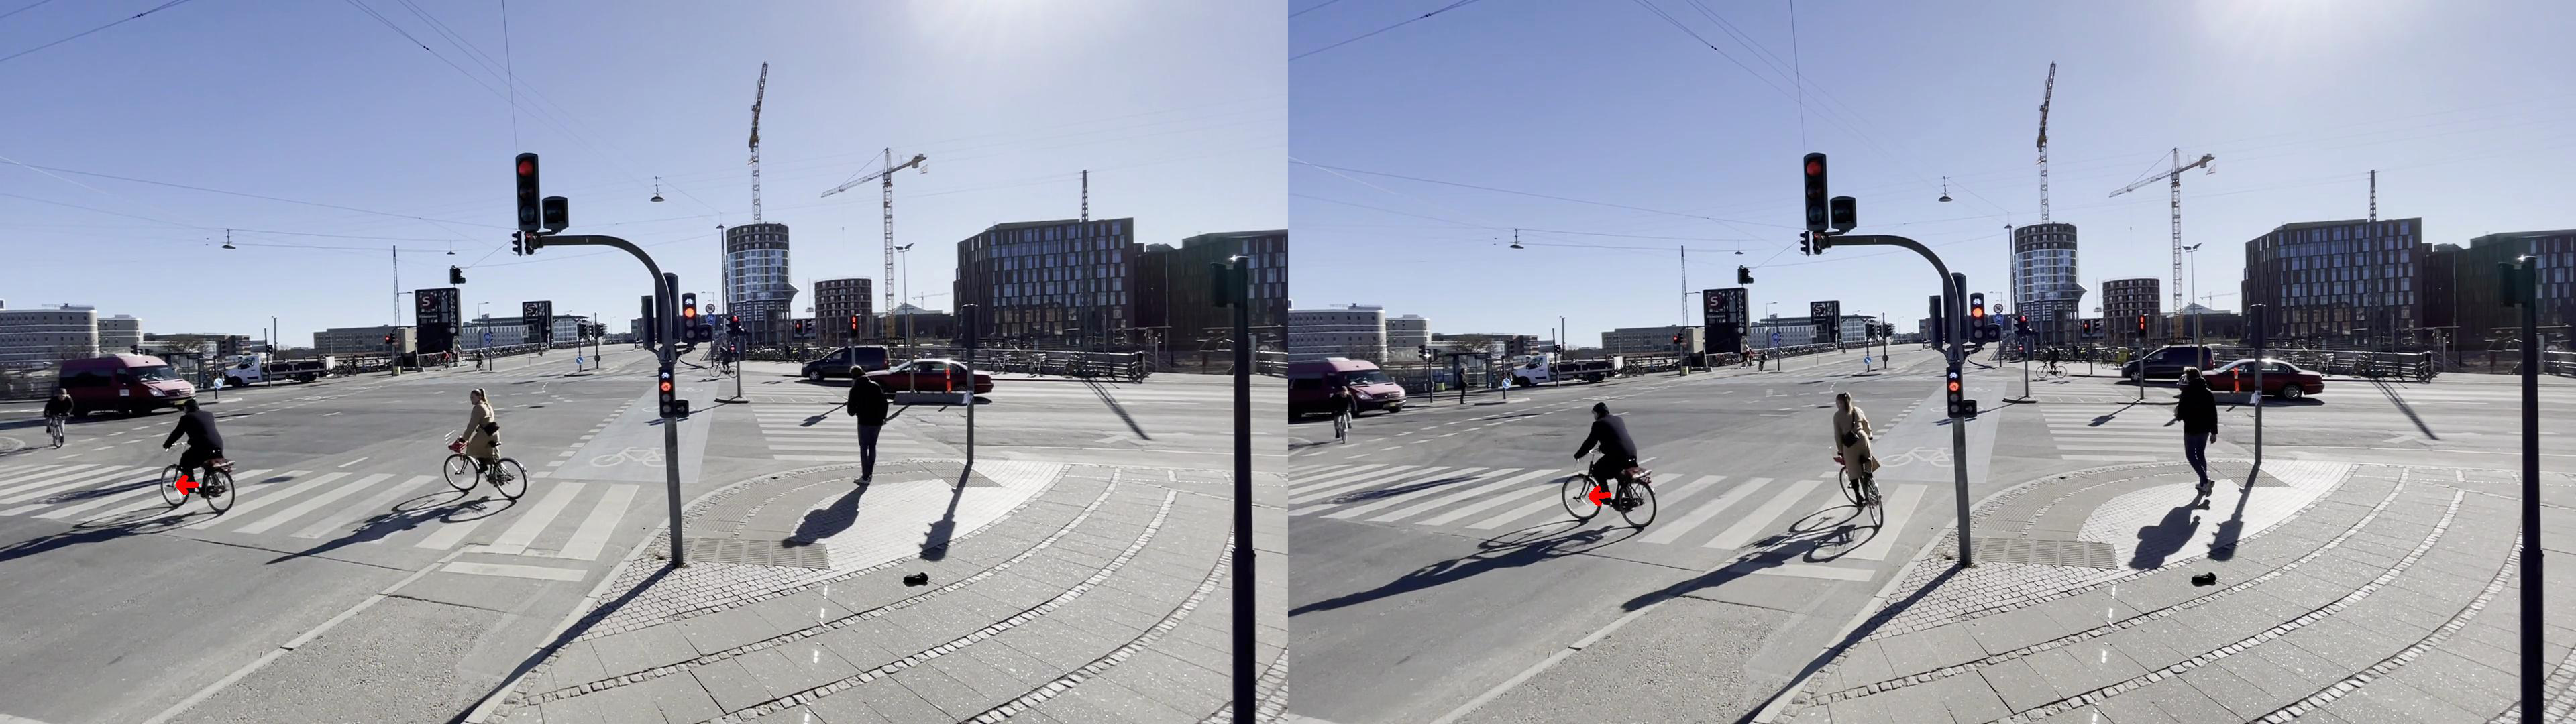

ValueError: invalid literal for int() with base 10: ''

In [24]:
labels = label_photos(photo_path, merged_df)

In [12]:
def add_labels_df(labels, merged_df):
    for key, value in labels.items():
        merged_df.loc[merged_df["UniqueID"]==key, "path"]=value[0]
        merged_df.loc[merged_df["UniqueID"]==key, "mode"]=value[1]
    return merged_df

def save_labels(labels, file_name, save_labels_path):
    json_file = json.dumps(labels)
    f = open(f"save_labels_path{file_name}_labels.json","w")
    f.write(json_file)
    f.close()
    return "saved"

merged_df = add_labels_df(labels, merged_df)
save_labels(labels, file_name, save_labels_path)

'saved'